In [ ]:
# %%

import numpy as np

import matplotlib.pyplot as plt

from scipy import signal
from scipy.io import wavfile

import IPython.display as ipd
from rich import progress
from numba import jit

In [ ]:
# %%

fs, audio = wavfile.read("notebooks/6th_E_steel_noisy.wav")

# NOTE: the diff * diff op in YIN can overflow without this normalization
audio = audio / 32768

ipd.Audio(audio, rate=fs)

In [ ]:
# %%

# Step 3 modification:
# Find min of parabola, assuming we've 3 points and buffer[x_min] is smallest
@jit
def parabola_interp(x_min: int, y_left: float, y_center: float, y_right: float):
    nom: float = (
        -4 * x_min * y_center + (2 * x_min - 1) * y_right + (2 * x_min + 1) * y_left
    )
    denom: float = 2 * (y_left - 2 * y_center + y_right)
    if denom == 0:
        return x_min
    estimator: float = nom / denom
    if estimator < x_min - 1 or estimator > x_min + 1:
        return x_min
    return nom / denom


@jit
def yin_pitch_detection(
    audio_buffer: np.ndarray,
    sample_rate: float,
    min_freq: float,
    max_freq: float,
    threshold: float,
):
    tau_min = int(sample_rate / max_freq)
    tau_max = int(sample_rate / min_freq)
    buffer_size = len(audio_buffer)
    buffer = np.zeros(buffer_size)

    # Step 1: Compute the difference function
    for tau in range(tau_min, tau_max):
        sum_diff = 0.0
        for j in range(buffer_size - tau):
            diff = audio_buffer[j] - audio_buffer[j + tau]
            sum_diff += diff * diff
        buffer[tau] = sum_diff

    # Step 2: Compute the cumulative mean normalized difference function (CMND)
    acc = 0.0
    for tau in range(tau_min, tau_max):
        acc += buffer[tau]
        buffer[tau] = buffer[tau] * (tau + 1 - tau_min) / acc

    # Step 3: Find the minimum value in the CMND function
    min_tau = -1
    min_tau_raw = -1
    for tau in range(tau_min + 1, tau_max - 1):
        # Modified (see last part of the notebook)
        # if buffer[tau] < 0.2:
        if buffer[tau] < threshold and buffer[tau] < buffer[tau + 1]:
            min_tau_raw = tau
            min_tau = parabola_interp(
                tau, buffer[tau - 1], buffer[tau], buffer[tau + 1]
            )
            break

    if min_tau == -1:
        return -1.0, -1.0  # No pitch detected within range

    return sample_rate / min_tau, buffer[min_tau_raw]

In [ ]:
# %%

# test_audio = audio_filt
test_audio = audio

In [ ]:
# %%

# window_size should match app's buffer size
# 44100 [samples/sec] / 15 [buffers/sec] = 2940 [samples / buffer]
window_size = 2940
hop_size = window_size

# Restricts frequency search range and increases threshold after 2 consecutive detections
ENABLE_FILTER = True

FREQ_MIN_DEFAULT = 30
FREQ_MAX_DEFAULT = 500
freq_min = FREQ_MIN_DEFAULT
freq_max = FREQ_MAX_DEFAULT

THRESHOLD_DEFAULT = 0.1
THRESHOLD_NOISY = 0.6
threshold = THRESHOLD_DEFAULT

# An RMS increase above this factor is considered a new stroke
RMS_GAP = 1.1

# Compute pitch over sliding windows
pitch_times = []
pitch_values = []
freq_span = []
rms_values = []
tau_values = []
MAX_FREQ_DEV = 0.2


# Aux func to measure relative difference
rel_diff = lambda x1, x2: abs(x1 - x2) / abs(x2)

for i in progress.track(range(0, len(test_audio) - window_size, hop_size)):
    window = test_audio[i : i + window_size]
    rms = np.sqrt(np.sum(window**2))
    # RMS is decreasing, and latest pitches were similar, restrict freq. range and loose threshold
    if (
        ENABLE_FILTER
        and len(rms_values) > 1
        and rms < rms_values[-1] * RMS_GAP
        and pitch_values[-1] > 0
        and (diff_relative := rel_diff(pitch_values[-1], pitch_values[-2]))
        < MAX_FREQ_DEV
    ):
        freq_min = pitch_values[-1] * (1 - MAX_FREQ_DEV)
        freq_max = pitch_values[-1] * (1 + MAX_FREQ_DEV)
        threshold = THRESHOLD_NOISY
        freq_span.append([freq_min, freq_max])
    else:
        freq_min = FREQ_MIN_DEFAULT
        freq_max = FREQ_MAX_DEFAULT
        threshold = THRESHOLD_DEFAULT
        freq_span.append(-1)
    pitch, min_tau = yin_pitch_detection(window, fs, freq_min, freq_max, threshold)
    # print(f"{pitch:.2f}Hz  [{freq_min:.2f}Hz-{freq_max:.2f}Hz] RMS: {rms:.4f}")
    pitch_times.append(i / fs)
    pitch_values.append(pitch)
    rms_values.append(rms)
    tau_values.append(min_tau)

Output()

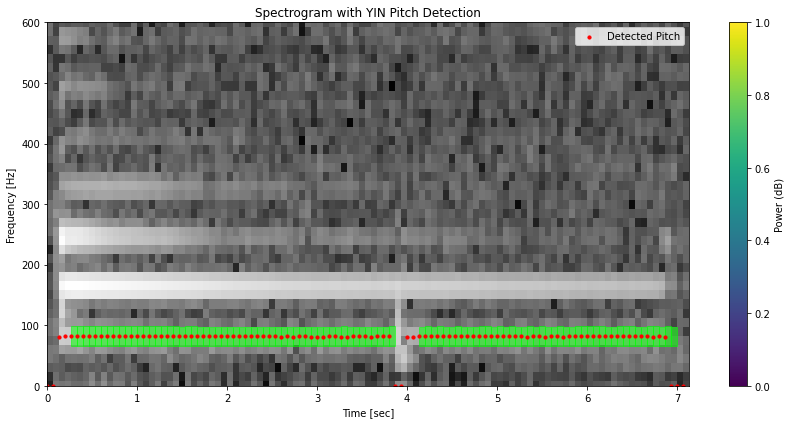

In [ ]:
# %%

# Plot spectrogram
f, t, S = signal.spectrogram(
    test_audio,
    fs,
    nperseg=window_size,
    noverlap=window_size - hop_size,
    mode="psd",
    window="hann",
)
S_db = 20 * np.log10(S + 1e-10)  # Avoid log(0)

plt.figure(figsize=(12, 6))
plt.pcolormesh(t, f, S_db, cmap="gray", shading="auto")
y_max = FREQ_MAX_DEFAULT + 100
plt.ylim([0, y_max])  # Focus on relevant frequencies

# Plot transparent frequency span
for idx, span in enumerate(freq_span[:-1]):
    if span != -1:
        plt.axvspan(
            pitch_times[idx],
            pitch_times[idx + 1],
            span[0] / y_max,
            span[1] / y_max,
            color="#00ff0088",
        )

# Overlay detected pitch (plot pitch=-1 in pitch=0)
pitch_points = np.array(pitch_values).clip(0)
pitch_times = np.array(pitch_times)
plt.scatter(pitch_times, pitch_points, c="r", s=10, label="Detected Pitch")

# Labels and formatting
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [sec]")
plt.colorbar(label="Power (dB)")
plt.title("Spectrogram with YIN Pitch Detection")
plt.legend()
plt.tight_layout()
plt.show()

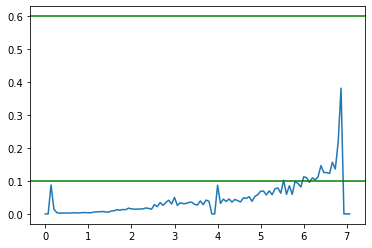

In [ ]:
# %%

# Plot min tau
plt.figure()
plt.plot(pitch_times, np.array(tau_values).clip(0))
plt.axhline(y=THRESHOLD_DEFAULT, color="g", marker=",")
plt.axhline(y=THRESHOLD_NOISY, color="g", marker=",")

# ---------------------------------------------------------

# %% [markdown]

 # Step by step YIN detection

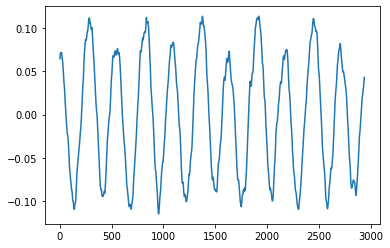

In [ ]:
t = 2.5
win_begin = int(t * fs)
audio_chunk = audio[win_begin : win_begin + window_size]

plt.figure()
plt.plot(audio_chunk)

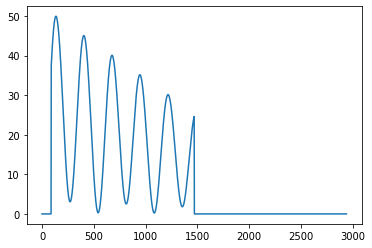

In [ ]:
# %%

audio_buffer = audio_chunk
freq_min = FREQ_MIN_DEFAULT
freq_max = FREQ_MAX_DEFAULT
threshold = THRESHOLD_DEFAULT

tau_min = int(fs / freq_max)
tau_max = int(fs / freq_min)
buffer_size = len(audio_buffer)
buffer = np.zeros(buffer_size)

# Step 1: Compute the difference function
for tau in range(tau_min, tau_max):
    sum_diff = 0.0
    for j in range(buffer_size - tau):
        diff = audio_buffer[j] - audio_buffer[j + tau]
        sum_diff += diff * diff
    buffer[tau] = sum_diff
plt.figure()
plt.plot(buffer)

(88.0, 1470.0)

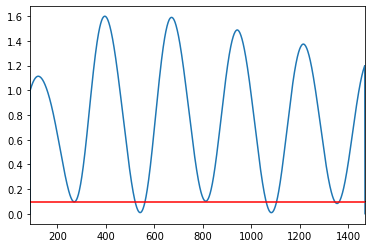

In [ ]:
# %%

# Step 2: Compute the cumulative mean normalized difference function (CMND)
acc = 0.0
for tau in range(tau_min, tau_max):
    acc += buffer[tau]
    buffer[tau] = buffer[tau] * (tau + 1 - tau_min) / acc

plt.figure()
plt.plot(buffer)
plt.axhline(y=threshold, color="r", marker=",")
plt.xlim(tau_min, tau_max)

In [ ]:
# %%

# Step 3: Find the minimum value in the CMND function
# min_tau = -1
# for tau in range(tau_min, tau_max):
#     if buffer[tau] < threshold:
#         min_tau = tau
#         break

# print(f"Pitch: {fs / min_tau:.2f} | Min tau: {min_tau}")


# Step 3 modification:
# falling below threshold is very naive and produces error
# (358Hz vs. 327Hz audacity for 1st_E string)
# Modification: find valley instead of simple threshold
# min_tau = -1
# for tau in range(tau_min + 1, tau_max - 1):
#     if buffer[tau] < threshold and buffer[tau] < buffer[tau + 1]:
#         min_tau = tau
#         break

# print(f"Pitch: {fs / min_tau:.2f} | Min tau: {min_tau}")


# Step 3 with parabaola interpolation
min_tau = -1
min_tau_raw = -1
for tau in range(tau_min + 1, tau_max - 1):
    if buffer[tau] < threshold and buffer[tau] < buffer[tau + 1]:
        min_tau = parabola_interp(tau, buffer[tau - 1], buffer[tau], buffer[tau + 1])
        min_tau_raw = tau
        break

print(
    f"Pitch: {fs / min_tau:.2f} | Min tau: {min_tau} | Min value: {buffer[min_tau_raw]}"
)

Pitch: 163.42 | Min tau: 269.8606838743599 | Min value: 0.09756203192776698
